In [1]:
from __future__ import annotations
import numpy as np

unexpanded_labels = np.load("/home/user/documents/PiereLab/lysozyme/lysozyme-stain-quantification/component development/mergeLogic/unmerged_labels_prev.npy")
expanded_labels = np.load("/home/user/documents/PiereLab/lysozyme/lysozyme-stain-quantification/component development/mergeLogic/unmerged_labels.npy")

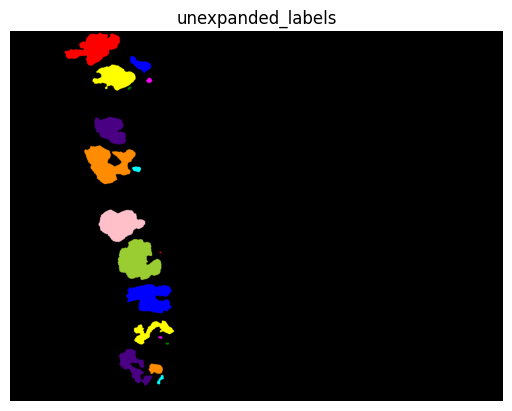

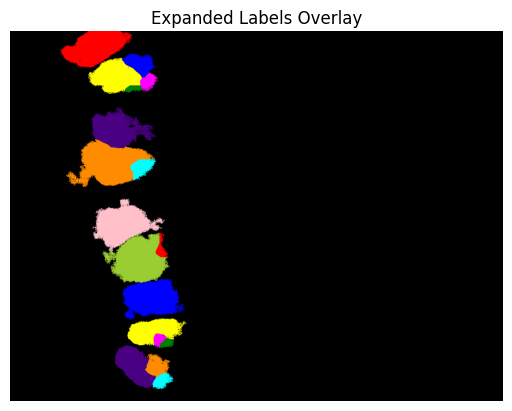

In [2]:

from skimage.color import label2rgb
from matplotlib import pyplot as plt

colored = label2rgb(unexpanded_labels, bg_label=0)

plt.imshow(colored)
plt.title("unexpanded_labels")
plt.axis('off')
plt.show()

colored = label2rgb(expanded_labels, bg_label=0)
plt.imshow(colored)
plt.title("Expanded Labels Overlay")
plt.axis('off')
plt.show()


1) Basic stats & adjacency

In [11]:
import numpy as np
from skimage.measure import regionprops, perimeter
from skimage.morphology import dilation, rectangle
from itertools import combinations
from collections import defaultdict

def compute_stats_and_adjacency(label_img):
    props    = {r.label: r for r in regionprops(label_img)}
    perims   = {lbl: perimeter(label_img == lbl) for lbl in props}
    centroids= {lbl: props[lbl].centroid for lbl in props}
    areas    = {lbl: props[lbl].area     for lbl in props}
    
    # adjacency: shared perimeter between i↔j
    shared = defaultdict(lambda: defaultdict(int))
    for lbl in props:
        mask = label_img == lbl
        dil  = dilation(mask, rectangle(3,3))
        neighs = set(np.unique(label_img[dil])) - {0, lbl}
        for n in neighs:
            shared_p = int(np.logical_and(dil, label_img==n).sum())
            shared[lbl][n] = shared_p
            shared[n][lbl] = shared_p
    
    return props, perims, centroids, areas, shared

props, perims, cents, areas, shared = compute_stats_and_adjacency(expanded_labels)
print("Properties:", props)


Properties: {1: <skimage.measure._regionprops.RegionProperties object at 0x7f5b37a0b880>, 2: <skimage.measure._regionprops.RegionProperties object at 0x7f5b37a0bdc0>, 3: <skimage.measure._regionprops.RegionProperties object at 0x7f5b3760ffd0>, 4: <skimage.measure._regionprops.RegionProperties object at 0x7f5b3760f460>, 5: <skimage.measure._regionprops.RegionProperties object at 0x7f5b3762e040>, 6: <skimage.measure._regionprops.RegionProperties object at 0x7f5b48edaf40>, 7: <skimage.measure._regionprops.RegionProperties object at 0x7f5b375c4ee0>, 8: <skimage.measure._regionprops.RegionProperties object at 0x7f5b375c45e0>, 9: <skimage.measure._regionprops.RegionProperties object at 0x7f5b375c4dc0>, 10: <skimage.measure._regionprops.RegionProperties object at 0x7f5b377946a0>, 11: <skimage.measure._regionprops.RegionProperties object at 0x7f5b37794dc0>, 12: <skimage.measure._regionprops.RegionProperties object at 0x7f5b37683b80>, 13: <skimage.measure._regionprops.RegionProperties object at

In [4]:
import pandas as pd

# Flatten shared adjacency into a list of 1-1 mappings
data = [
    {"label1": i, "label2": j, "shared_perimeter": w}
    for i, nbrs in shared.items()
    for j, w in nbrs.items()
    if i < j and w > 0
]

# Create DataFrame and display it
df = pd.DataFrame(data)
print(df)


    label1  label2  shared_perimeter
0        1       3                 6
1        3       4                27
2        3       5                54
3        2       3               100
4        2       4                30
5        4       5                16
6        6       7               109
7        7       8               125
8        9      10                70
9       10      11               101
10      10      12                32
11      13      14                76
12      13      15                22
13      14      15                43
14      16      17                93
15      16      18                35
16      17      18                41


/home/user/documents/PiereLab/lysozyme/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


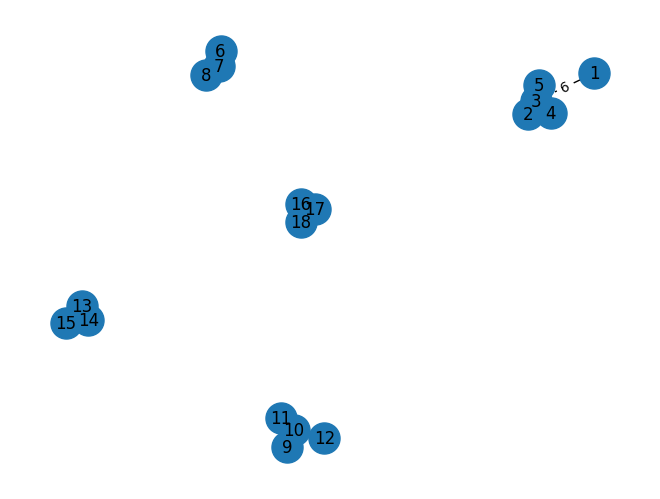

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for i, nbrs in shared.items():
    for j, w in nbrs.items():
        if w>0 and i<j:
            G.add_edge(i, j, weight=w)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


## stage 1
### find all 3 member or 
so now lets get on with the first stage merge evaluation, where we will go through each label, find all cliques up to 3 members in size which it is part of ( that includes the singleton self, any 2 memeber cliuques we can direclty pull from the mappings and then the triangles) we will then check against each triangle its a part of whether or not we should treat them as a chained unit ( i.e. if two triangles share 2 members including the label of interenst(so merge candidates can be larger then 3 memebrs by this)) 
then now against each of these candidite groups we have defined we will calculate the first parameter in oder to identify the best fit of nearby neigbors to eventualy merge it with.
i will be adjusting the parameters, but for now they will be: (total perimeter of the subject in contact with members of the merge candidate group)/( total perimeter of the subject(to avoid divide by 0 errors)), and against singletons it will be 1/ a factor passed as the argument, that way it will set like a minimum amount of coverage requireed

In [6]:
from collections import defaultdict
from itertools import combinations

def find_triangles(shared_adjacency):
    """
    Given a shared adjacency dictionary {label: {neighbor_label: shared_perimeter}},
    find all unique 3-cliques (triangles) where all three labels are mutually connected.
    
    Returns:
        triangles: List of tuples (a, b, c) where a, b, c are labels in a triangle.
    """
    triangles = set()
    for a in shared_adjacency:
        neighbors_a = set(shared_adjacency[a])
        for b, c in combinations(neighbors_a, 2):
            if b in shared_adjacency[c] and c in shared_adjacency[b]:
                triangle = tuple(sorted((a, b, c)))
                triangles.add(triangle)
    return sorted(triangles)

# # Example usage mock
# example_shared = {
#     1: {2: 5, 3: 5},
#     2: {1: 5, 3: 5},
#     3: {1: 5, 2: 5},
#     4: {5: 5},
#     5: {4: 5}
# }# note the :5 is a placeholder for shared perimeter, not used in this function

# triangles = find_triangles(example_shared)

# Example usage with actual shared adjacency
triangles = find_triangles(shared)
print("Triangles found:", triangles)

Triangles found: [(2, np.int32(3), np.int32(4)), (np.int32(3), np.int32(4), np.int32(5)), (13, np.int32(14), np.int32(15)), (16, np.int32(17), np.int32(18))]


In [16]:
def build_candidate_groups(shared, triangles, singleton_penalty=5.0):
    """
    For each label, generate all valid merge candidate groups:
    - Self group
    - Direct 2-member cliques
    - 3-member triangles
    - Chained triangles (sharing 2 nodes including current label)
    """
    # reverse index triangles by label
    triangle_index = defaultdict(list)
    for tri in triangles:
        for lbl in tri:
            triangle_index[lbl].append(tri)

    combos_by_label = defaultdict(list)
    for lbl in shared:
        # (1) Self combo
        combos_by_label[lbl].append((lbl,))

        # (2) 2-element combos
        for n in shared[lbl]:
            if lbl < n:  # avoid duplicates like (3, 4) and (4, 3)
                combos_by_label[lbl].append(tuple(sorted((lbl, n))))

        # (3) 3-element triangles
        combos_by_label[lbl].extend(triangle_index[lbl])

        # (4) Extended groups via chained triangles
        seen = set()
        for tri1 in triangle_index[lbl]:
            for tri2 in triangle_index[lbl]:
                if tri1 == tri2:
                    continue
                inter = set(tri1).intersection(tri2)
                if len(inter) == 2 and lbl in inter:
                    merged = tuple(sorted(set(tri1).union(tri2)))
                    if merged not in seen:
                        combos_by_label[lbl].append(merged)
                        seen.add(merged)

    return combos_by_label
combos = build_candidate_groups(shared, triangles)
print("Combos by label:", combos)



Combos by label: defaultdict(<class 'list'>, {1: [(1,), (1, np.int32(3))], np.int32(3): [(np.int32(3),), (np.int32(3), np.int32(4)), (np.int32(3), np.int32(5)), (2, np.int32(3), np.int32(4)), (np.int32(3), np.int32(4), np.int32(5)), (2, np.int32(3), np.int32(4), np.int32(5))], 2: [(2,), (2, np.int32(3)), (2, np.int32(4)), (2, np.int32(3), np.int32(4))], np.int32(4): [(np.int32(4),), (np.int32(4), np.int32(5)), (2, np.int32(3), np.int32(4)), (np.int32(3), np.int32(4), np.int32(5)), (2, np.int32(3), np.int32(4), np.int32(5))], np.int32(5): [(np.int32(5),), (np.int32(3), np.int32(4), np.int32(5))], 6: [(6,), (6, np.int32(7))], np.int32(7): [(np.int32(7),), (np.int32(7), np.int32(8))], np.int32(8): [(np.int32(8),)], 9: [(9,), (9, np.int32(10))], np.int32(10): [(np.int32(10),), (np.int32(10), np.int32(11)), (np.int32(10), np.int32(12))], np.int32(11): [(np.int32(11),)], np.int32(12): [(np.int32(12),)], 13: [(13,), (13, np.int32(14)), (13, np.int32(15)), (13, np.int32(14), np.int32(15))], np

🧠 Core Logic Overview
find_triangles(shared)

Detects all 3-label cliques (fully connected triangles).

A triangle [A, B, C] is valid if A↔B, B↔C, and C↔A are all neighbors.

build_candidate_groups(shared, triangles)

For each label ℓ, builds a list of candidate groups to consider merging with:

Singleton group (ℓ,)

All direct 2-member pairs including ℓ

All triangles that include ℓ

Extended merge groups: formed by merging triangles that share 2 members including ℓ, allowing expansion beyond 3 elements

evaluate_first_stage_merges(...)

For each label ℓ, scores all candidate merge groups

Score formula:

If group is a singleton (ℓ,): 1 / singleton_penalty

Else: score = shared_perimeter_with_group / total_perimeter_of_ℓ

Selects the best scoring group as the first-stage merge candidate

In [18]:

def evaluate_first_stage_merges(combos_by_label, perims, shared, singleton_penalty=5.0):
    """
    Returns the best merge candidate for each label based on:
    - (total shared perimeter with group) / (total exposed perimeter)
    """
    best_combo_by_label = {}
    for lbl, combo_list in combos_by_label.items():
        P = perims[lbl]
        best_score = -1.0
        best_combo = (lbl,)
        for combo in combo_list:
            if combo == (lbl,):
                score = 1.0 / singleton_penalty
            else:
                shared_sum = sum(shared[lbl][n] for n in combo if n != lbl)
                score = shared_sum / (P + 1e-8)
            if score > best_score:
                best_score = score
                best_combo = combo
        best_combo_by_label[lbl] = (best_combo, best_score)
    return best_combo_by_label
best_first_stage = evaluate_first_stage_merges(combos, perims, shared)
print("Best first stage merges:", best_first_stage)


Best first stage merges: {1: ((1,), 0.2), np.int32(3): ((2, np.int32(3), np.int32(4), np.int32(5)), np.float64(0.30533895899777613)), 2: ((2, np.int32(3), np.int32(4)), np.float64(0.3290580564834091)), np.int32(4): ((2, np.int32(3), np.int32(4), np.int32(5)), np.float64(0.2926428855009503)), np.int32(5): ((np.int32(3), np.int32(4), np.int32(5)), np.float64(0.5121633519985898)), 6: ((6,), 0.2), np.int32(7): ((np.int32(7),), 0.2), np.int32(8): ((np.int32(8),), 0.2), 9: ((9,), 0.2), np.int32(10): ((np.int32(10),), 0.2), np.int32(11): ((np.int32(11),), 0.2), np.int32(12): ((np.int32(12),), 0.2), 13: ((13,), 0.2), np.int32(14): ((13, np.int32(14), np.int32(15)), np.float64(0.8755292773417148)), np.int32(15): ((13, np.int32(14), np.int32(15)), np.float64(0.42756298145249255)), 16: ((16, np.int32(17), np.int32(18)), np.float64(0.24077698804485012)), np.int32(17): ((16, np.int32(17), np.int32(18)), np.float64(0.32179806622653784)), np.int32(18): ((16, np.int32(17), np.int32(18)), np.float64(0.

4) Pick the best merge partner for each ℓ

In [8]:
# at the top of your cell/file
from skimage.measure._regionprops import RegionProperties

def build_swallow_map(
    combos: dict[int, list[tuple[int, ...]]],
    perims: dict[int, float],
    props: dict[int, RegionProperties],     # now this name actually exists
    areas: dict[int, int],
    shared: dict[int, dict[int, int]],
    sample_size: int = 100,
    eps: float = 1e-8
) -> dict[int, int]:
    swallow: dict[int, int] = {}
    for lbl, combo_list in combos.items():
        best_score = (-1.0, -1.0)
        best_combo: tuple[int, ...] | None = None

        for combo in combo_list:
            sc = score_label_combo(
                lbl, combo,
                perims, props, areas, shared,
                sample_size, eps
            )
            if sc > best_score:
                best_score, best_combo = sc, combo

        if best_combo is not None and len(best_combo) > 1:
            rep = max(best_combo, key=lambda n: areas[n] * perims[n])
            if rep != lbl:
                swallow[lbl] = rep

    return swallow


5) Apply the mapping

In [9]:
def apply_swallow(label_img, swallow_map):
    out = label_img.copy()
    for small, big in swallow_map.items():
        out[out==small] = big
    return out


END to end

In [10]:

combos = neighbor_combinations(shared, max_k=2)
swallow = build_swallow_map(combos, perims, cents, areas, shared)
merged  = apply_swallow(expanded_labels, swallow)


NameError: name 'neighbor_combinations' is not defined

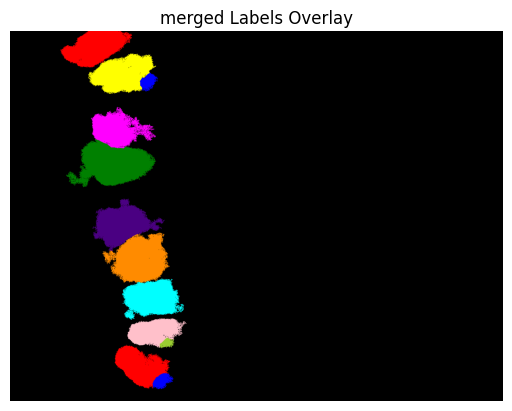

In [ ]:
colored = label2rgb(merged, bg_label=0)
plt.imshow(colored)
plt.title("merged Labels Overlay")
plt.axis('off')
plt.show()

KeyboardInterrupt: 

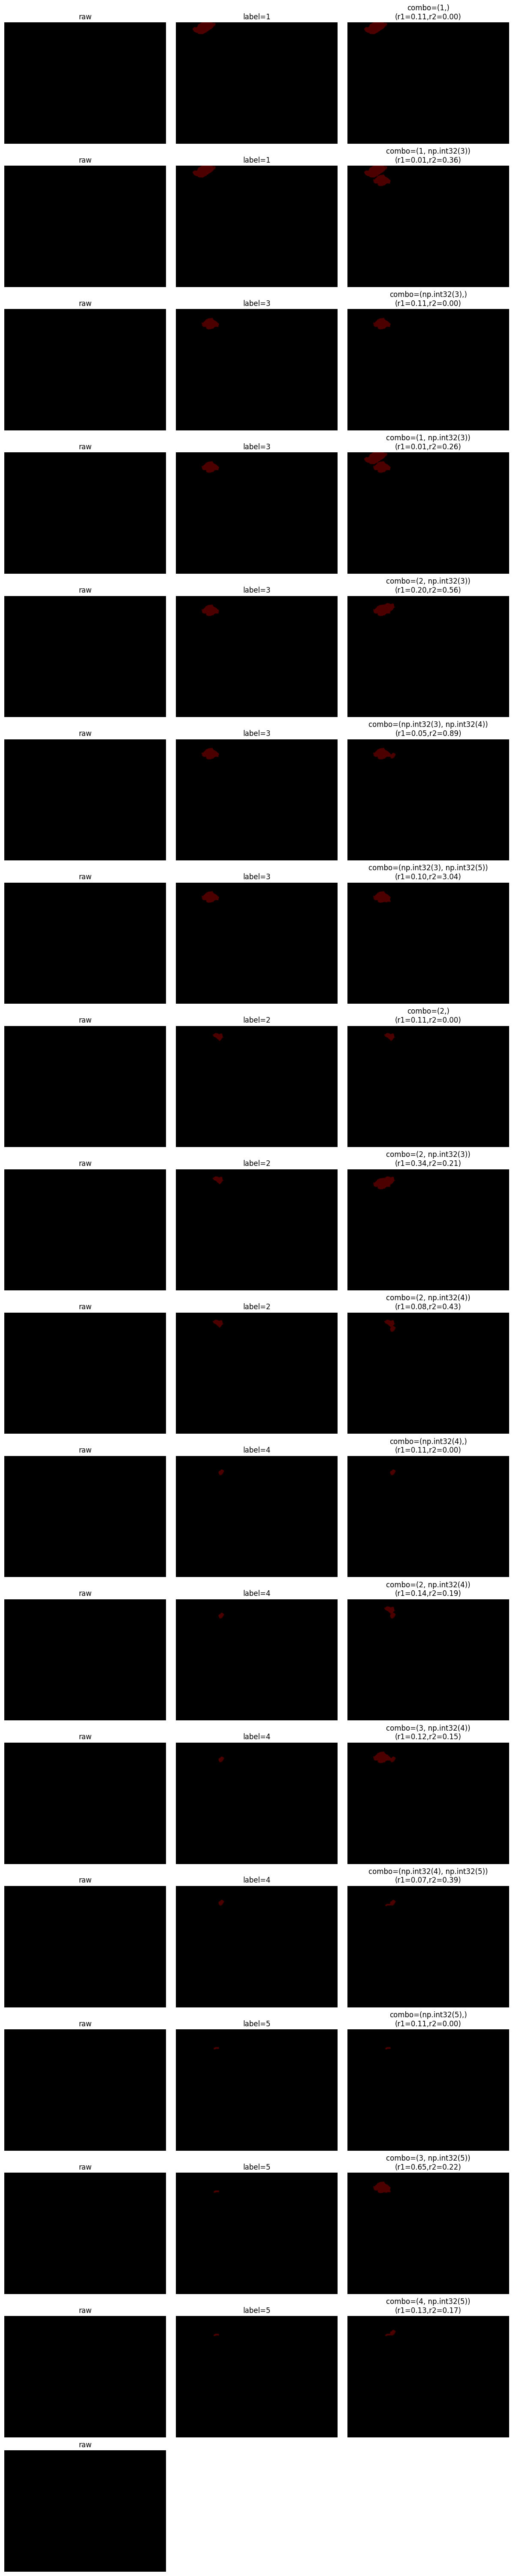

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

def render_merge_analysis(
    expanded_labels: np.ndarray,
    combos: dict[int, list[tuple[int, ...]]],
    perims: dict[int, float],
    cents: dict[int, tuple[float, float]],
    areas: dict[int, int],
    shared: dict[int, dict[int, int]],
    score_fn,
    raw_img: np.ndarray | None = None,
    figsize_per_row: tuple[int,int] = (12, 3),
):
    """
    For every label ℓ and every candidate combo C ∋ ℓ, plot:
      [ raw | ℓ-overlay | (ℓ merged with C\{ℓ})-overlay ]
    and print (ratio1, ratio2) above each row.

    Parameters
    ----------
    expanded_labels : 2D label array from your watershed
    combos          : mapping ℓ → list of tuples (ℓ, …)
    perims, cents, areas, shared : same dicts as before
    score_fn        : function(lbl, combo, …) → (ratio1, ratio2)
    raw_img         : H×W×3 or H×W image, or None → will use black background
    figsize_per_row : size of each row in inches
    """
    n_plots = sum(len(c_list) for c_list in combos.values())
    fig = plt.figure(constrained_layout=True, figsize=(figsize_per_row[0], figsize_per_row[1]*n_plots))
    gs = fig.add_gridspec(n_plots, 3)

    row = 0
    # prepare a black background if raw_img is empty
    if raw_img is None or np.all(raw_img == 0):
        bg = np.zeros((*expanded_labels.shape, 3), dtype=np.uint8)
    else:
        # if grayscale, stack to RGB
        if raw_img.ndim == 2:
            bg = np.stack([raw_img]*3, axis=-1)
        else:
            bg = raw_img.copy()

    for lbl, combo_list in combos.items():
        for combo in combo_list:
            ratio1, ratio2 = score_fn(lbl, combo, perims, cents, areas, shared)
            # 1) raw
            ax0 = fig.add_subplot(gs[row, 0])
            ax0.imshow(bg)
            ax0.set_title("raw")
            ax0.axis("off")

            # 2) ℓ overlay
            mask_lbl = (expanded_labels == lbl)
            ov0 = label2rgb(mask_lbl.astype(int), image=bg, bg_label=0)
            ax1 = fig.add_subplot(gs[row, 1])
            ax1.imshow(ov0)
            ax1.set_title(f"label={lbl}")
            ax1.axis("off")

            # 3) merged overlay
            merged = expanded_labels.copy()
            for l in combo:
                if l != lbl:
                    merged[merged == l] = lbl
            # show only the merged ℓ-region (others masked out)
            merged_mask = (merged == lbl)
            ov1 = label2rgb(merged_mask.astype(int), image=bg, bg_label=0)
            ax2 = fig.add_subplot(gs[row, 2])
            ax2.imshow(ov1)
            ax2.set_title(f"combo={combo}\n(r1={ratio1:.2f},r2={ratio2:.2f})")
            ax2.axis("off")

            row += 1

    plt.show()
    
def auto_merge_pipeline(
    expanded_labels: np.ndarray,
    raw_img: np.ndarray | None = None,
    max_k: int = 2
):
    """
    Runs the full merge-logic pipeline:
      1. compute_stats_and_adjacency
      2. neighbor_combinations
      3. build_swallow_map
      4. apply_swallow

    Returns
    -------
    merged_labels : np.ndarray
      The label image after one round of optimal, pairwise greedy merges.
    swallow_map : dict[int,int]
      Mapping small_label → chosen big_label.
    combos : dict[int, list[tuple[int,...]]]
      All candidate combos per label.
    perims, cents, areas, shared : the stats dicts for further analysis.
    """
    # 1) stats + adjacency
    props, perims, cents, areas, shared = compute_stats_and_adjacency(expanded_labels)

    # 2) combos (including the self-merge option)
    combos = neighbor_combinations(shared, max_k=max_k)

    # 3) decide who swallows whom
    swallow = build_swallow_map(combos, perims, cents, areas, shared)

    # 4) apply
    merged = apply_swallow(expanded_labels, swallow)

    return merged, swallow, combos, perims, cents, areas, shared

# assume you’ve already got `expanded_labels` and (optionally) your `red_image`

merged, swallow_map, combos, perims, cents, areas, shared = auto_merge_pipeline(
    expanded_labels,
    raw_img=None,  # or your raw image array
    max_k=2
)



# Or run the detailed render:
render_merge_analysis(
    expanded_labels,
    combos,
    perims,
    cents,
    areas,
    shared,
    score_label_combo
)


In [ ]:
# assume you already have:
# combos, perims, cents, areas, shared from auto_merge_pipeline

print(f"{'Label':>5}  {'Combo':>15}   {'ratio1':>8}   {'ratio2':>8}   shared_sum  exposed  dist_to_COM")
for lbl, combo_list in combos.items():
    for combo in combo_list:
        # compute raw stats
        shared_sum = sum(shared[lbl].get(n, 0) for n in combo if n!=lbl)
        exposed    = perims[lbl] - shared_sum
        # compute distance to COM
        com_y = sum(areas[n]*cents[n][0] for n in combo) / sum(areas[n] for n in combo)
        com_x = sum(areas[n]*cents[n][1] for n in combo) / sum(areas[n] for n in combo)
        dy = cents[lbl][0] - com_y
        dx = cents[lbl][1] - com_x
        dist = (dy*dy + dx*dx)**0.5

        # get the ratios
        r1, r2 = score_label_combo(lbl, combo, perims, cents, areas, shared)

        print(f"{lbl:5d}   {str(combo):15s}   {r1:8.3f}   {r2:8.3f}   {shared_sum:10d}   {exposed:8.1f}   {dist:8.2f}")


Label            Combo     ratio1     ratio2   shared_sum  exposed  dist_to_COM
    1   (1,)                 0.000   1389285367.765            0      783.4       0.00
    1   (1, np.int32(3))      0.008      0.358            6      777.4      38.44
    3   (np.int32(3),)       0.000   1355300108.612            0      592.8       0.00
    3   (1, np.int32(3))      0.010      0.264            6      586.8      52.07
    3   (2, np.int32(3))      0.203      0.564          100      492.8      19.87
    3   (np.int32(3), np.int32(4))      0.048      0.894           27      565.8      12.44
    3   (np.int32(3), np.int32(5))      0.100      3.044           54      538.8       3.88
    2   (2,)                 0.000   771514581.663            0      395.1       0.00
    2   (2, np.int32(3))      0.339      0.214          100      295.1      52.38
    2   (2, np.int32(4))      0.082      0.429           30      365.1      15.84
    4   (np.int32(4),)       0.000   533171284.543            0   